<a href="https://colab.research.google.com/github/mkelly7/ecoe-stats/blob/main/t_test_bq_austin_bikeshare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-cloud-bigquery
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
!pip install scipy
!pip install numpy
!pip install matplotlib
!pip install seaborn

Data type of 'duration_minutes' after conversion: float64
Group A size: 14425, Group B size: 12584
Group A data type: float64, Group B data type: float64
T-statistic: 1.6559826995640428, P-value: 0.0977369399962124
Group A Mean: 36.14793760831889, 95% CI: [33.141267256124735, 39.15460796051305]
Group B Mean: 32.951525746980295, 95% CI: [30.82358692110693, 35.07946457285366]


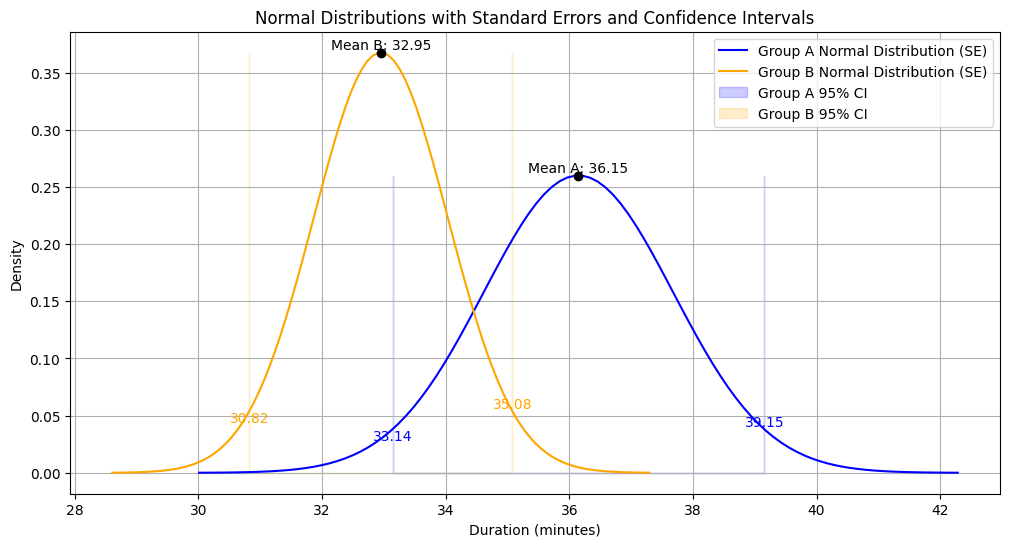

In [6]:
import os
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#gc = gspread.authorize(creds)
from google.cloud import bigquery

# This line might not be necessary if using Google Colab, but should be executed outside
# of Colab environment, following Google Cloud's user authentication instructions.
# Comment this out for testing in Colab
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

# Get the project ID from the environment or set it manually
# project_id = os.environ.get("GOOGLE_CLOUD_PROJECT")  # Try to get it from environment
project_id = 'gcp-wow-food-wlx-digaspt-dev' # Replace 'gcp-project-id' with your actual GCP project ID
# If the above doesn't work, set `project_id` to your actual project ID

# Construct a BigQuery client object.
client = bigquery.Client(credentials=creds, project=project_id)

# Initialize BigQuery client
# client = bigquery.Client()

# SQL Query
query = """
SELECT start_station_id, duration_minutes
FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
WHERE start_station_id IN (2562, 2544)
LIMIT 28000
"""

# Run the query
query_job = client.query(query)
results = query_job.result()

# Convert results to DataFrame
df = results.to_dataframe()

# Reset index
df = df.reset_index(drop=True)

# Ensure 'start_station_id' is treated as an integer
df['start_station_id'] = df['start_station_id'].astype(int)

# Convert 'duration_minutes' to numeric, forcing invalid values to NaN
df['duration_minutes'] = pd.to_numeric(df['duration_minutes'], errors='coerce')

# Drop rows where 'duration_minutes' is NaN
df = df.dropna(subset=['duration_minutes'])

# Explicitly convert 'duration_minutes' to float
df['duration_minutes'] = df['duration_minutes'].astype(float)

# Verify that the conversion was successful
print(f"Data type of 'duration_minutes' after conversion: {df['duration_minutes'].dtype}")

# Splitting the data by group
group_a = df[df['start_station_id'] == 2562]['duration_minutes']
group_b = df[df['start_station_id'] == 2544]['duration_minutes']

# Ensure both groups are not empty and are numeric
print(f"Group A size: {len(group_a)}, Group B size: {len(group_b)}")
print(f"Group A data type: {group_a.dtype}, Group B data type: {group_b.dtype}")

# Perform a t-test (only if both groups are valid)
if len(group_a) > 0 and len(group_b) > 0:
    t_stat, p_value = stats.ttest_ind(group_a, group_b)
    print(f"T-statistic: {t_stat}, P-value: {p_value}")
else:
    print("Error: One or both groups have no valid data for the t-test.")

# Calculate means and standard errors
mean_a = group_a.mean()
mean_b = group_b.mean()
std_a = group_a.std()
std_b = group_b.std()
n_a = len(group_a)
n_b = len(group_b)

# Calculate standard errors
se_a = std_a / np.sqrt(n_a)
se_b = std_b / np.sqrt(n_b)

# Calculate 95% confidence intervals using SE
ci_a = 1.96 * se_a
ci_b = 1.96 * se_b

lower_ci_a = mean_a - ci_a
upper_ci_a = mean_a + ci_a
lower_ci_b = mean_b - ci_b
upper_ci_b = mean_b + ci_b

print(f"Group A Mean: {mean_a}, 95% CI: [{lower_ci_a}, {upper_ci_a}]")
print(f"Group B Mean: {mean_b}, 95% CI: [{lower_ci_b}, {upper_ci_b}]")

# Create a plot
plt.figure(figsize=(12, 6))

# Plotting the normal distribution using SE for each group
x_a = np.linspace(mean_a - 4*se_a, mean_a + 4*se_a, 100)
y_a = stats.norm.pdf(x_a, mean_a, se_a)
plt.plot(x_a, y_a, label='Group A Normal Distribution (SE)', color='blue')

x_b = np.linspace(mean_b - 4*se_b, mean_b + 4*se_b, 100)
y_b = stats.norm.pdf(x_b, mean_b, se_b)
plt.plot(x_b, y_b, label='Group B Normal Distribution (SE)', color='orange')

# Plotting the confidence intervals
plt.fill_betweenx(y_a, lower_ci_a, upper_ci_a, color='blue', alpha=0.2, label='Group A 95% CI')
plt.fill_betweenx(y_b, lower_ci_b, upper_ci_b, color='orange', alpha=0.2, label='Group B 95% CI')

# Adding data labels for means and confidence intervals
plt.scatter([mean_a, mean_b], [stats.norm.pdf(mean_a, mean_a, se_a), stats.norm.pdf(mean_b, mean_b, se_b)],
            color='black', zorder=5)

# Mean labels
plt.text(mean_a, stats.norm.pdf(mean_a, mean_a, se_a), f'Mean A: {mean_a:.2f}',
         horizontalalignment='center', verticalalignment='bottom')
plt.text(mean_b, stats.norm.pdf(mean_b, mean_b, se_b), f'Mean B: {mean_b:.2f}',
         horizontalalignment='center', verticalalignment='bottom')

# Confidence interval labels at the actual y-value of the normal distribution
plt.text(lower_ci_a, stats.norm.pdf(lower_ci_a, mean_a, se_a), f'{lower_ci_a:.2f}',
         horizontalalignment='center', verticalalignment='top', color='blue')
plt.text(upper_ci_a, stats.norm.pdf(upper_ci_a, mean_a, se_a), f'{upper_ci_a:.2f}',
         horizontalalignment='center', verticalalignment='bottom', color='blue')

plt.text(lower_ci_b, stats.norm.pdf(lower_ci_b, mean_b, se_b), f'{lower_ci_b:.2f}',
         horizontalalignment='center', verticalalignment='top', color='orange')
plt.text(upper_ci_b, stats.norm.pdf(upper_ci_b, mean_b, se_b), f'{upper_ci_b:.2f}',
         horizontalalignment='center', verticalalignment='bottom', color='orange')

# Labels and title
plt.title('Normal Distributions with Standard Errors and Confidence Intervals')
plt.xlabel('Duration (minutes)')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

# Alternative version

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [5]:
%%bigquery df --project gcp-wow-food-wlx-digaspt-dev

SELECT start_station_id, duration_minutes
FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
WHERE start_station_id IN (2562, 2544)
LIMIT 28000

Query is running:   0%|          |

Downloading:   0%|          |